In [1]:
!pip install wfdb
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
# 📚 Import all required libraries
import os
import glob
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam

In [3]:
# 🔗 Clone your GitHub repo (public)
!git clone https://github.com/rajeshkumar-niet/ECG.git

# 📂 Set path to NSTDB files inside your repo
data_path = "/content/ECG/Data/"

Cloning into 'ECG'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 68 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 22.39 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
# 📥 Load ECG signals from NSTDB using WFDB
def load_ecg_signals(data_path):
    records = [f for f in os.listdir(data_path) if f.endswith(".hea")]
    signals = []

    for rec in records:
        rec_path = os.path.join(data_path, rec.replace(".hea", ""))
        try:
            signal, _ = wfdb.rdsamp(rec_path)
            if signal.shape[0] >= 2048:
                signals.append(signal[:2048, 0])  # Take first channel and 2048 samples
        except Exception as e:
            print(f"Error loading {rec_path}: {e}")
    return np.array(signals)


In [5]:
# 🔊 Add Gaussian noise
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, -1.0, 1.0)


In [6]:
# 🧠 Define 1D CNN Autoencoder
def build_autoencoder(input_shape):
    input_sig = Input(shape=input_shape)

    x = Conv1D(32, 3, activation='relu', padding='same')(input_sig)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling1D(2, padding='same')(x)

    x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)

    decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_sig, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
    return autoencoder


In [7]:
# 📊 Load and prepare data
signals = load_ecg_signals(data_path)
signals = (signals - np.min(signals)) / (np.max(signals) - np.min(signals))  # Normalize

noisy_signals = add_noise(signals)

# Reshape for Conv1D: (samples, time_steps, channels)
X = signals[..., np.newaxis]
X_noisy = noisy_signals[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X_noisy, X, test_size=0.2, random_state=42)


In [8]:
# 🎯 Train model
autoencoder = build_autoencoder(input_shape=(2048, 1))
history = autoencoder.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1194 - val_loss: 0.1213
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1186 - val_loss: 0.1197
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1177 - val_loss: 0.1179
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1167 - val_loss: 0.1159
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.1156 - val_loss: 0.1137
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.1143 - val_loss: 0.1112
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1129 - val_loss: 0.1084
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1112 - val_loss: 0.1051
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1094 - val_loss: 0.1014
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.1074 - val_loss: 0.0972
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1052 - val_loss: 0.0925
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.1028 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


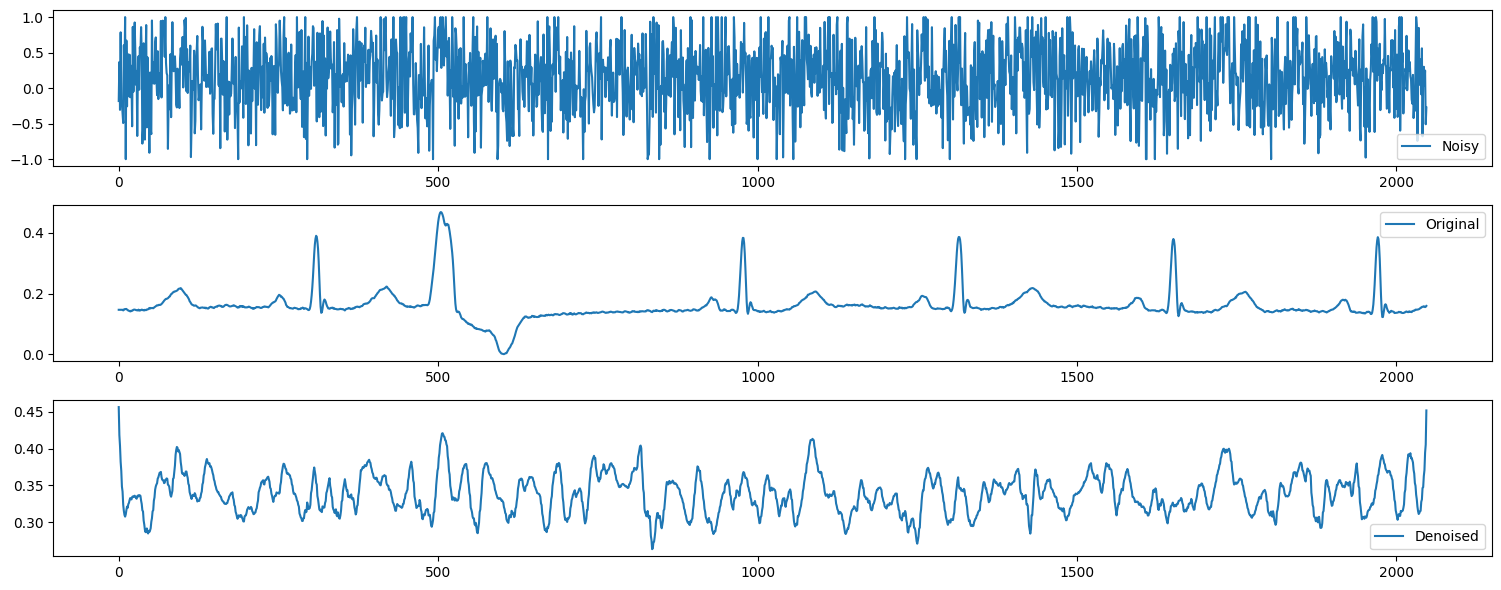

In [9]:
# 📈 Plot original vs noisy vs denoised
def plot_denoising(index=0):
    denoised = autoencoder.predict(X_test)
    plt.figure(figsize=(15, 6))

    plt.subplot(3, 1, 1)
    plt.plot(X_test[index].squeeze(), label="Noisy")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(y_test[index].squeeze(), label="Original")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(denoised[index].squeeze(), label="Denoised")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 🔍 Call the function to visualize a sample
plot_denoising(index=0)


In [10]:
# 💾 Save the trained model
autoencoder.save('/content/autoencoder_ecg_model.h5')
print("Model saved successfully!")


Model saved successfully!


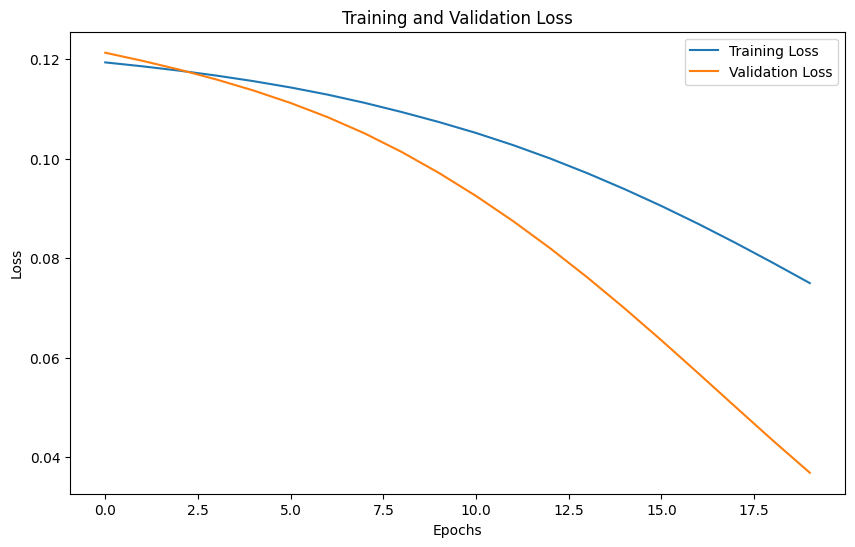

In [11]:
# 📉 Plot training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 🔍 Call the function to plot training history
plot_training_history(history)


In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
# 📁 Define path in your Google Drive where you want to save the model
drive_model_path = "/content/drive/MyDrive/ECG"

In [14]:
# 📤 Copy the model to Google Drive
import shutil
shutil.copy("/content/autoencoder_ecg_model.h5", drive_model_path)
print(f"✅ Model uploaded to Google Drive at: {drive_model_path}")


✅ Model uploaded to Google Drive at: /content/drive/MyDrive/ECG


In [15]:
drive_model_path = "/content/drive/MyDrive/autoencoder_ecg_model.h5"
shutil.copy("/content/autoencoder_ecg_model.h5", drive_model_path)
print(f"✅ Model uploaded to Google Drive at: {drive_model_path}")


✅ Model uploaded to Google Drive at: /content/drive/MyDrive/autoencoder_ecg_model.h5
